### Imports

In [1]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re

sys.path.append("../")
pl.Config.set_tbl_rows(50)

polars.config.Config

In [129]:
def regex_search(
    regex_string: str,
    column: str,
    dataframe: pl.DataFrame,
) -> pl.DataFrame:

    def search_condition(x):
        try:
            found = re.search(regex_string, x).group(1)
        except AttributeError:
            # match not found in the original string
            found = ""  # apply your error handling
        return found

    new_column = dataframe.with_columns(
        c(column)
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("new_column")
    )["new_column"]

    return new_column

### table creation

In [2]:
dir_path = "../data/parsed_dataframes"
file_name = "epic_records_8500.parquet"
file_path = os.path.join(dir_path, file_name)
epic_records = pd.read_parquet(file_path)

In [3]:
for column in epic_records.columns:
    epic_records[column] = epic_records[column].replace(to_replace="nan", value=np.nan)
    epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_69601/633498768.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")


In [4]:
epic_records = (
    pl.from_pandas(epic_records)
    .with_columns(
        c("Дата поступления")
        .cast(pl.String)
        .str.to_datetime("%d.%m.%Y %H:%M")
        .dt.date(),
        # c("lab_date").cast(pl.String).str.to_datetime("%d.%m.%Y %H:%M").dt.date(),
    )
    .rename({"Дата поступления": "admission_datetime"})
    .drop(["birthday", "record"])
    # .head(2)
)

In [5]:
epic_records.head(2)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,date,str,str,str,str,str
"""75DB9BE5-92BE-432F-AA97-2CC5A5…","""Мужской""","""ОБЩЕБИОГРАФИЧЕСКИЕ СВЕДЕНИЯ Н…","""АНАМНЕЗ ИБС С 2016Г., КОГДА ПЕ…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip.""","""ИБС. Прогрессирующая стенокард…","""Гипертоническая болезнь 3 стад…","""['I50.9']""","""['I20.0']""","""['E11.8', 'I10', 'E66.9']""",2023-04-03,"""Первичный""","""Плановая госпитализация""",null,null,null
"""55218D18-4928-6138-E055-000000…","""Мужской""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС С 198…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по KillipПароксизмальная…","""ИБС.Острый инфаркт миокарда пе…","""Варикозно расширенные вены пищ…","""['I48.0', 'I50.1']""","""['I21.0']""","""['B18.0', 'I85.9', 'I69.4']""",2019-01-19,"""Первичный""","""Доставлен бригадой скорой помо…","""Гипертоническая болезнь III ст…","""['I11.9']""",null


In [6]:
epic_records.shape

(8506, 21)

### create target

In [7]:
# all desease codes
(
    epic_records.filter(
        epic_records.select("patient_id").is_duplicated(),
    )
    .select(["main_disease_desc", "main_disease_code"])
    .with_columns(c("main_disease_code").str.slice(offset=2, length=3))[
        "main_disease_code"
    ]
    .value_counts()
    .sort(
        "count",
        descending=True,
    )
)

main_disease_code,count
str,u32
"""I20""",1141
"""I21""",1040
"""I25""",10
"""I50""",7
"""I11""",6
"""I47""",3
"""I22""",3
"""I48""",2
"""M42""",1


In [284]:
labeled_data = (
    epic_records
    # .filter(
    #     epic_records.select("patient_id").is_duplicated(),
    # )
    .with_columns(
        c("main_disease_code").str.slice(
            offset=2,
            length=3,
        )
    )
    .group_by("patient_id")
    .agg(
        pl.all().sort_by("admission_datetime").first(),
        c("admission_datetime")
        .sort_by("admission_datetime")
        .alias("following_admission_datetimes"),
        c("main_disease_code")
        .sort_by("admission_datetime")
        .alias("following_main_disease_codes"),
    )
    .with_columns(
        c("following_admission_datetimes").list.slice(offset=1),
        c("following_main_disease_codes").list.slice(offset=1),
    )
    .with_columns(
        pl.when(c("following_main_disease_codes").list.contains("I21"))
        .then(1)
        .when(c("following_main_disease_codes").list.contains("I22"))
        .then(1)
        .when(c("following_main_disease_codes").list.len().eq(0))
        .then(-1)
        .otherwise(0)
        .alias("target")
    )
)

In [159]:
labeled_data["target"].value_counts().sort("target")
# 1 - has IM
# 0 - no IM
# -1 - no info about outcome

target,count
i32,u32
-1,6289
0,518
1,473


### make features

In [160]:
labeled_data.shape

(7280, 24)

In [161]:
labeled_data.null_count()

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,76,3,1583,76,3,1583,0,0,0,1032,1032,7226,0,0,0


#### final_table2
- useless

In [162]:
pd.DataFrame(eval(labeled_data["final_table2"].to_numpy()[0]))

,Вид нозологической единицы,Врачебное описание нозологической единицы,Код по МКБ-10
0,Основное заболевание,ИБС. ПРОГРЕССИРУЮЩАЯ СТЕНОКАРДИЯ. МУЛЬТИФОКАЛЬ...,I20.0
1,Основное заболевание,ИБС. Прогрессирующая стенокардия. Мультифокаль...,I20.0
2,Осложнение основного заболевания,ОСН I по Killip,I50.1
3,Сопутствующее заболевание,Мультифокальный атеросклероз с поражением БЦС ...,I70.9
4,Сопутствующее заболевание,Ожирение I степени (ИМТ 34),E66.0
5,Сопутствующее заболевание,"!!!!!!!!!!!!!ная форма фибрилляции предсердий,...",I48.1
6,Фоновое заболевание,"СД 2 типа, целевой уровень гликированного гемо...",E11.8
7,Фоновое заболевание,Гипертоническая болезнь III стадии. Контролиру...,I11.9


In [163]:
# same values that are already in table

In [164]:
labeled_data = labeled_data.drop("final_table2")

#### final_table1 -> first gospitalization results
- Характер основного заболевания
- Результат обращения

In [293]:
# plt.hist
pl.from_pandas(
    pd.DataFrame(
        eval(
            labeled_data.with_columns(c("final_table1").str.len_chars().alias("fdsa"))
            .sort(["fdsa"])["final_table1"]
            .to_numpy()[241]
        )
    )
)

Характер основного заболевания,Исход госпитализации,Результат обращения,Признак подозрения на злокачественное новообразование,Признак развертывания индивидуального поста
str,str,str,str,str
"""Острое""","""None""","""Улучшение""","""Нет""","""Нет"""


In [294]:
(
    regex_search(
        regex_string=r"Признак развертывания индивидуального поста\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Нет""",7280


In [295]:
(
    regex_search(
        regex_string=r"Признак подозрения на злокачественное новообразование\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Нет""",7280


In [296]:
(
    regex_search(
        regex_string=r"Результат обращения\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Улучшение""",6899
"""Летальный исход""",217
"""Без изменения""",156
"""Ухудшение""",8


In [297]:
(
    regex_search(
        regex_string=r"Исход госпитализации\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""None""",7280


In [298]:
(
    regex_search(
        regex_string=r"Характер основного заболевания\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Острое""",7002
"""Ранее установленное хроническо…",204
"""None""",69
"""Впервые в жизни установленное …",5


In [314]:
new_columns_regex_final_table1 = {
    "main_desease_status": r"Характер основного заболевания\':\s{0:\s\'(\D*)\'}",
    "gospitalization_result": r"Результат обращения\':\s{0:\s\'(\D*)\'}",
}

In [315]:
section = "final_table1"
for column_name, regex_string in new_columns_regex_final_table1.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

In [ ]:
# labeled_data = labeled_data.drop("final_table1")

#### condition
- Состояние/статус
- у доли пациентов проводили начальное обследование. можно достать рост, вес и тд

In [301]:
print(eval(labeled_data["condition"][327])[-1])

Объективный статус: ОБЪЕКТИВНЫЙ СТАТУС:


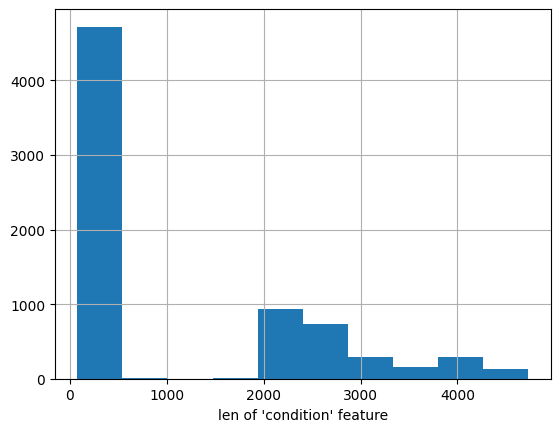

In [302]:
plt.hist(
    labeled_data.with_columns(c("condition").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'condition' feature")
plt.grid()

In [303]:
(
    regex_search(
        regex_string=r"(АРТЕРИАЛЬНОЕ ДАВЛЕНИЕ)",
        column="condition",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",5436
"""АРТЕРИАЛЬНОЕ ДАВЛЕНИЕ""",1844


In [304]:
(
    regex_search(
        regex_string=r"НАСЫЩЕНИЕ КРОВИ КИСЛОРОДОМ \(САТУРАЦИЯ, %\)\D*(\d+)",
        column="condition",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(5)
)

new_column,count
str,u32
"""""",5570
"""98""",864
"""97""",276
"""96""",201
"""99""",135


In [468]:
new_columns_regex_condition = {
    "oxygen_saturation": r"НАСЫЩЕНИЕ КРОВИ КИСЛОРОДОМ \(САТУРАЦИЯ, %\)\D*(\d+)",
    "bmi": r"ИМТ\D*(\d+)",
    "status": r"Состояние:\s*(.{2,24})',",
    # "left_atrium": r"ЛЕВОЕ",
}

In [469]:
section = "condition"

for column_name, regex_string in new_columns_regex_condition.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

#### full wards
- ecg
- rentgenogram
- ultrasound

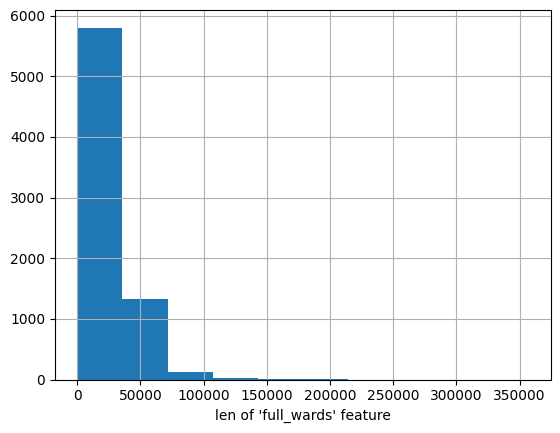

In [319]:
plt.hist(
    labeled_data.with_columns(c("full_wards").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'full_wards' feature")
plt.grid()

In [320]:
def clean_full_wards(x):
    x = x.replace("!", "")
    x = re.sub(
        r"{urn:hl7-org:v3}",
        "",
        x,
    )
    # x = re.sub(
    #     r"\'\D+\':",
    #     " ",
    #     x,
    # )
    # x = re.sub(
    #     r"[\\n{}\'\"]",
    #     " ",
    #     x,
    # )
    x = re.sub(
        r"  +",
        " ",
        x,
    )
    return x


labeled_data = labeled_data.with_columns(
    c("full_wards")
    .map_elements(
        clean_full_wards,
        return_dtype=str,
    )
    .alias("full_wards_cleaned")
)

In [321]:
labeled_data["full_wards_cleaned"][-4]

'{\'Сведения о пребывании пациента в Приемное отделение\': {\'Электрокардиография (14.10.2020 11:22)\': {\'table\': {\'col\': [{\'width\': \'12%\'}, {\'width\': \'88%\'}], \'tbody\': {\'tr\': [{\'td\': [{\'content\': {\'text\': \'Эффективная доза\'}}, {\'content\': {}}]}, {\'td\': [{\'content\': {\'text\': \'Протокол\'}}, {\'content\': {\'text\': \'"" \\n""\\n\\n\\nПРОТОКОЛ ОБСЛЕДОВАНИЯ № \\n\\n\\nФ.И.О.: А Н С\\nВОЗРАСТ (ДАТА РОЖДЕНИЯ): 57 ( 01.01.1698)\\nПРЕДВАРИТЕЛЬНЫЙ ДИАГНОЗ: \\nПО 14.10.2020 11:22\\nЗАКЛЮЧЕНИЕ:\\nСИНУСОВЫЙ МЕДЛЕННЫЙ РИТМ, ЧСС 59 УД/МИН.\\nЭОС ОТКЛОНЕНА ВЛЕВО. НЕПОЛНАЯ БПНПГИСА.\\nНЕБОЛЬШАЯ ЭЛЕВАЦИЯ С. ST III, AVF, С ИНВЕРСИЕЙ З.Т, МИКРО З.R.\\nИЗМЕНЕНИЯ ПРОЦЕССОВ РЕПОЛЯРИЗАЦИИ ВЕРХУШЕЧНОБОКОВОЙ СТЕНКИ ЛЖ.\\nНЕ ИСКЛЮЧАЕТСЯ ГЛЖ.\'}}]}, {\'td\': [{\'content\': {\'text\': \'Заключение\'}}, {\'content\': {\'text\': \'ЗАКЛЮЧЕНИЕ:\\nСИНУСОВЫЙ МЕДЛЕННЫЙ РИТМ, ЧСС 59 УД/МИН.\\nЭОС ОТКЛОНЕНА ВЛЕВО. НЕПОЛНАЯ БПНПГИСА.\\nНЕБОЛЬШАЯ ЭЛЕВАЦИЯ С. ST III, AVF, С ИНВЕРСИЕЙ З.Т, МИ

In [322]:
pd.DataFrame(eval(labeled_data["full_wards_cleaned"][-4]))

,Сведения о пребывании пациента в Приемное отделение,Сведения о пребывании пациента в Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №2,Сведения о пребывании пациента в Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1,Сведения о пребывании пациента в Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №2
Электрокардиография (14.10.2020 11:22),"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN,NaN
Электрокардиография (17.10.2020 00:06),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (19.10.2020 08:12),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (19.10.2020 08:36),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (19.10.2020 09:53),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (19.10.2020 09:55),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Ультразвуковое исследование экстракраниального отдела брахиоцефальных артерий с функциональными пробами (19.10.2020 14:08),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (19.10.2020 14:16),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (20.10.2020 09:00),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN
Электрокардиография (20.10.2020 09:03),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN,NaN


In [ ]:
# print
# (
# pd.DataFrame(eval(labeled_data["full_wards_cleaned"][-4]))
# .loc[
#     "Рентгеноскопия грудной клетки (14.02.2023 20:55)",
#     "Сведения о пребывании пациента в Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1",
# ]
# ['table']
# ['tbody']['tr']
# [1]['td'][1]['content']['text']
# .keys()
# )

##### ECG features

In [459]:
new_columns_regex_ecg = {
    "ecg_right_atrium": r"ПРАВОЕ ПРЕДСЕРДИЕ:.*?(\d+[,.]\d+)",
    "ecg_left_atrium": r"ЛЕВОЕ ПРЕДСЕРДИЕ:.*?(\d+[,.]\d+)",
    "ecg_right_ventricle": r"ПРАВЫЙ ЖЕЛУДОЧЕК:.*?(\d+[,.]\d+)",
    "ecg_end_diastolic_volume": r"КДО:\s*(\d+)*",
    "ecg_end_systolic_volume": r"КСО:\s*(\d+)*",
    "ecg_stroke_volume": r"УО:\s*(\d+)*",
    "ecg_ejection_fraction": r"ФВ:\s*(\d+[-.,]\d+|\d+)*",
    "ecg_ventricular_septal": r"МЖП:\s*(\d+[,.]\d+)",
    "ecg_e_a": r"Е/А\s*(\d+[,.]\d+)",
    "ecg_aorta_diameter_valsalva_sinuses": r"ДИАМЕТР АО НА УРОВНЕ СИНУСОВ ВАЛЬСАЛЬВЫ:\s*(\d+[,.]\d+)",
    "ecg_ascending_aorta": r"ВОСХОДЯЩАЯ АОРТА:\s*(\d+[,.]\d+)",
    "ecg_aortic_arch": r"ДУГА АОРТЫ.\s*(\d+[,.]\d+)",
    "ecg_sinus_heart_rate": r"СИНУСОВЫЙ.{0,7}ЧСС\s*(\d+[,.]\d+)",
    "ecg_age": r"ДАТА РОЖДЕНИЯ\):\s(\d{2}) ",
    "ecg_heart_rate": r"ЧСС\s*[-,:РАВЕН]*\s*(\d{2,4})",
    "ecg_bmi": r"ИМТ\D*(\d+)",
    # "left_atrium": r"ЛЕВОЕ",
}

In [460]:
section = "full_wards"
for column_name, regex_string in new_columns_regex_ecg.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

##### potential features

In [ ]:
(
    regex_search(
        regex_string=r"(ЭЛЕВАЦИЯ.{0,7}СЕГМЕНТА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",6080
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В ОТВ.""",167
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В II, """,150
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В ОТВЕ""",101
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST ОБЩЕЙ """,73
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В V1-V""",71
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В III,""",47
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST, ПАТОЛ""",32
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST И ВЫСО""",27


In [ ]:
(
    regex_search(
        regex_string=r"(РЕПОЛЯРИЗАЦИ..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",3377
"""РЕПОЛЯРИЗАЦИИ НИЖНЕЙ С""",514
"""РЕПОЛЯРИЗАЦИИ ПЕРЕДНЕ-""",501
"""РЕПОЛЯРИЗАЦИИ БОКОВОЙ """,395
"""РЕПОЛЯРИЗАЦИИ НИЖНЕ-БО""",275
"""РЕПОЛЯРИЗАЦИИ ПЕРЕДНЕ """,243
"""РЕПОЛЯРИЗАЦИИ ВЕРХУШЕЧ""",228
"""РЕПОЛЯРИЗАЦИИ НИЖНЕЙ, """,152
"""РЕПОЛЯРИЗАЦИИ МИОКАРДА""",137


In [ ]:
(
    regex_search(
        regex_string=r"(ТИЧЕСКАЯ БЛЯШКА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",3712
"""ТИЧЕСКАЯ БЛЯШКА В УСТЬЕ """,672
"""ТИЧЕСКАЯ БЛЯШКА В УСТЬЕ""",562
"""ТИЧЕСКАЯ БЛЯШКА В БИФУРКА""",395
"""ТИЧЕСКАЯ БЛЯШКА В БИФУР""",257
"""ТИЧЕСКАЯ БЛЯШКА В БИФУРК""",235
"""ТИЧЕСКАЯ БЛЯШКА, СТЕНОЗИР""",216
"""ТИЧЕСКАЯ БЛЯШКА В БАССЕЙН""",156
"""ТИЧЕСКАЯ БЛЯШКА ПО ЗАДНЕ""",121


In [ ]:
(
    regex_search(
        regex_string=r"(ТЕНЬ СЕРДЦА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",7113
"""ТЕНЬ СЕРДЦА РАСШИРЕНА""",57
"""ТЕНЬ СЕРДЦА НЕЗНАЧИТЕ""",42
"""ТЕНЬ СЕРДЦА ВИЗУАЛЬНО""",19
"""ТЕНЬ СЕРДЦА НЕ РАСШИР""",14
"""ТЕНЬ СЕРДЦА УМЕРЕННО """,8
"""ТЕНЬ СЕРДЦА ОБЫЧНОЙ К""",6
"""ТЕНЬ СЕРДЦА ЗНАЧИТЕЛЬ""",5
"""ТЕНЬ СЕРДЦА ПРОЕКЦИОН""",3


In [ ]:
(
    regex_search(
        regex_string=r"(АОРТА ................)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""АОРТА СМ. \nАОРТАЛЬНЫЙ""",2657
"""АОРТА НЕ РАСШИРЕНА, КО""",918
"""АОРТА НЕ РАСШИРЕНА.\nК""",892
"""""",779
"""АОРТА СМ. АОРТАЛЬНЫЙ К""",352
"""АОРТА ЧЕТКО НЕ ДИФФЕРЕ""",266
"""АОРТА С РОВНЫМ ЧЕТКИМ """,258
"""АОРТА ЧАСТИЧНО ДИФФЕРЕ""",201
"""АОРТА НЕ РАСШИРЕНА.КУП""",88


In [ ]:
(
    regex_search(
        regex_string=r"(..............ГИДРОТОРАКС.......)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",6300
"""ЛЕВОСТОРОННИЙ ГИДРОТОРАКС.'}}]…",76
"""КТИКА/РЕГРЕСС ГИДРОТОРАКСА, НО…",38
"""ЕВОСТОРОННЕГО ГИДРОТОРАКСА.'}}…",37
""" ДВУСТОРОННИЙ ГИДРОТОРАКС.'}}]…",32
"""ДВУСТОРОННЕГО ГИДРОТОРАКСА.'}}…",20
"""2-Х СТОРОННИЙ ГИДРОТОРАКС.'}}]…",17
"""ЕВОСТОРОННЕГО ГИДРОТОРАКСА, СО…",16
"""АВОСТОРОННЕГО ГИДРОТОРАКСА.'}}…",14


In [ ]:
(
    regex_search(
        regex_string=r"(..СЕРДЦЕ..............)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""\nСЕРДЦЕ НЕ РАСШИРЕНО.""",2010
"""""",1265
"""\nСЕРДЦЕ ПРОЕКЦИОННО Р""",685
"""\nСЕРДЦЕ ОБЫЧНО РАСПОЛ""",523
"""\nСЕРДЦЕ ОБЫЧНОЙ КОНФИ""",454
"""\nСЕРДЦЕ И КРУПНЫЕ СОС""",416
"""\nСЕРДЦЕ ВИЗУАЛЬНО НЕ """,189
"""\nСЕРДЦЕ РАСШИРЕНО.\nА""",180
"""\nСЕРДЦЕ НЕ РАСШИРЕНО,""",171


In [ ]:
(
    pd.DataFrame(eval(labeled_data["full_wards"][3])).loc[
        "Электрокардиография (25.09.2022 01:15)",
        "Сведения о пребывании пациента в Приемное отделение",
    ]
)

{'{urn:hl7-org:v3}table': {'{urn:hl7-org:v3}col': [{'width': '12%'},
   {'width': '88%'}],
  '{urn:hl7-org:v3}tbody': {'{urn:hl7-org:v3}tr': [{'{urn:hl7-org:v3}td': [{'{urn:hl7-org:v3}content': {'text': 'Эффективная доза'}},
      {'{urn:hl7-org:v3}content': {}}]},
    {'{urn:hl7-org:v3}td': [{'{urn:hl7-org:v3}content': {'text': 'Протокол'}},
      {'{urn:hl7-org:v3}content': {'text': '"" \n""\n!\n\nПРОТОКОЛ ОБСЛЕДОВАНИЯ № !!!!!!!!!!!!!\n\n\nФ.И.О.: С В И\nВОЗРАСТ (ДАТА РОЖДЕНИЯ): 66 ( 01.01.1698!)\n25.09.22 ПО\nЗАКЛЮЧЕНИЕ:\nРИТМ СИНУСОВЫЙ УСКОРЕННЫЙ С ЧСС 96 В МИН\nЭОС ОТКЛОНЕНА РЕЗКО ВЛЕВО. \nБЛОКАДА ЛЕВОЙ НОЖКИ ПУЧКА ГИСА.\nЭЛЕВАЦИЯ ST V1-V5'}}]},
    {'{urn:hl7-org:v3}td': [{'{urn:hl7-org:v3}content': {'text': 'Заключение'}},
      {'{urn:hl7-org:v3}content': {'text': 'ЗАКЛЮЧЕНИЕ:\nРИТМ СИНУСОВЫЙ УСКОРЕННЫЙ С ЧСС 96 В МИН\nЭОС ОТКЛОНЕНА РЕЗКО ВЛЕВО. \nБЛОКАДА ЛЕВОЙ НОЖКИ ПУЧКА ГИСА.\nЭЛЕВАЦИЯ ST V1-V5'}}]},
    {'{urn:hl7-org:v3}td': [{'{urn:hl7-org:v3}content': {'text': 'Выявленна

In [ ]:
print(
    "Ф.И.О.: М В М\nВОЗРАСТ (ДАТА РОЖДЕНИЯ): 73 ( 01.01.1698!) \nПРЕДВАРИТЕЛЬНЫЙ ДИАГНОЗ: ИБС. ИНФАРКТ МИОКАРДА НИЖНЕ-ЗАДНЕЙ СТЕНКИ С ПОДЪЕМОМ СЕГМЕНТА ST ОТ 21.07.2022. КОРОНАРНАЯ БАЛОННАЯ АНГИОПЛАСТИКА СО СТЕНТИРОВАНИЕМ ПР/3 - СР/3 ОВ КАЛИПСО 4,0 X 33 MM (KL33400) ОТ 21.07.2022\nРЕЗУЛЬТАТЫ ОБСЛЕДОВАНИЯ:\nПРАВОЕ ПРЕДСЕРДИЕ:  3,6 СМ.; \tПРАВЫЙ ЖЕЛУДОЧЕК: 3,0 СМ.; \nЛЕВОЕ ПРЕДСЕРДИЕ: 4,3 СМ.; В ДЛИНУ: 5,3СМ.; ОБЪЕМ 67 МЛ. S ЛП 21,1 СМ2 \nЛЕВЫЙ ЖЕЛУДОЧЕК: КДО: 125 МЛ.; КСО: 70 МЛ.; УО:  55  МЛ.; ФВ: 45 % \nМЖП: 1,5 СМ ; НЕОПРЕДЕЛЕННЫЙ ТИП ДВИЖЕНИЯ \nЗАДНЯЯ СТЕНКА: 1,15 СМ.; УМЕРЕННЫЙ ГИПОКИНЕЗ\nНИЖНЯЯ СТЕНКА УМЕРЕННЫЙ ГИПОКИНЕЗ\nМИТРАЛЬНЫЙ КЛАПАН: СТВОРКИ НЕ УПЛОТНЕНЫ, ПРОТИВОФАЗА СОХРАНЕНА \n\tРСМК - СМ.;\tФК В ДИАСТОЛУ - СМ.;\nМИТРАЛЬНОЕ ОТВЕРСТИЕ: СМ2.; Д - СМ2\nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 1,8 ММ. РТ. СТ. СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 0,7 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: ДО 2 (25% ОТ S ЛП), ЦЕНТРАЛЬНАЯ СТРУЯ, V.C 0,5 СМ, S РЕГ. СТРУИ 5,4 СМ2 \nЕ/А 0,7 DT МС. \nАОРТА: СТЕНКИ УПЛОТНЕНЫ, АМПЛИТУДА ИХ ДВИЖЕНИЯ СОХРАНЕНА \nФИБРОЗНОЕ КОЛЬЦО: 2.1 СМ.;  УПЛОТНЕНО, ЕДИНИЧНЫЙ КАЛЬЦИНАТ;\nДИАМЕТР АО НА УРОВНЕ СИНУСОВ ВАЛЬСАЛЬВЫ: 3,5 СМ. ВОСХОДЯЩАЯ АОРТА: 3,6 СМ..;\nДУГА АОРТЫ  СМ ПЕРЕШЕЕК    ММ.РТ.СТ. НИСХОДЯЩАЯ АОРТА СМ. \nАОРТАЛЬНЫЙ КЛАПАН: СТВОРКИ УПЛОТНЕНЫ ОТКРЫТИЕ 2,0СМ. \nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 5.4 ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 1,1М/С. СТЕПЕНЬ РЕГУРГИТАЦИИ: ; S РЕГ. СТРУИ СМ2 \nТРИКУСПИДАЛЬНЫЙ КЛАПАН: ИНТАКТНЫЙ \nГРАДИЕНТ ДАВЛЕНИЯ ПИК: ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: М/С. СТЕПЕНЬ РЕГУРГИТАЦИИ:1\nЛЕГОЧНАЯ АРТЕРИЯ: ФК 2,6 СМ, СТВОЛ: СМ, ПРАВАЯ ВЕТВЬ СМ, ЛЕВАЯ: СМ.\nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 2,8 ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 0.8 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: 1\nСИСТ. ДАВЛЕНИЕ В ЛЕГОЧНОЙ АРТЕРИИ: ММ. РТ. СТ. ПО ПОТОКУ TR 28 ММ. РТ. СТ.\nПЕРИКАРД: Б/О. ЧСС: УД. В МИН. \nЗАКЛЮЧЕНИЕ:\nСОСТОЯНИЕ ПОСЛЕ СТЕНТИРОВАНИЯ ОВ ОТ 21.07.22 \nУМЕРЕННЫЙ ГИПОКИНЕЗ НИЖНЕ-БАЗАЛЬНЫХ, ЗАДНЕ БАЗАЛЬНЫХ СЕГМЕНТОВ ЛЖ.\nУВЕЛИЧЕНИЕ ПОЛОСТИ ЛЕВОГО ПРЕДСЕРДИЯ. \nНЕДОСТАТОЧНОСТЬ МК ДО 2 СТ.\nГИПЕРТРОФИЯ МЖП. \nДИАСТОЛИЧЕСКАЯ ДИСФУНКЦИЯ ЛЖ I ТИП (НАРУШЕНИЕ РЕЛАКСАЦИИ ЛЖ)\nФИБРОЗ КОРНЯ И СТЕНОК ВОСХОДЯЩЕЙ АОРТЫ\nСОКРАТИТЕЛЬНАЯ ФУНКЦИЯ МИОКАРДА УМЕРЕННО СНИЖЕНА. \nДАННЫХ ЗА ЖИДКОСТЬ В ПОЛОСТИ ПЕРИКАРДА НЕТ."
)

Ф.И.О.: М В М
ВОЗРАСТ (ДАТА РОЖДЕНИЯ): 73 ( 01.01.1698!) 
ПРЕДВАРИТЕЛЬНЫЙ ДИАГНОЗ: ИБС. ИНФАРКТ МИОКАРДА НИЖНЕ-ЗАДНЕЙ СТЕНКИ С ПОДЪЕМОМ СЕГМЕНТА ST ОТ 21.07.2022. КОРОНАРНАЯ БАЛОННАЯ АНГИОПЛАСТИКА СО СТЕНТИРОВАНИЕМ ПР/3 - СР/3 ОВ КАЛИПСО 4,0 X 33 MM (KL33400) ОТ 21.07.2022
РЕЗУЛЬТАТЫ ОБСЛЕДОВАНИЯ:
ПРАВОЕ ПРЕДСЕРДИЕ:  3,6 СМ.; 	ПРАВЫЙ ЖЕЛУДОЧЕК: 3,0 СМ.; 
ЛЕВОЕ ПРЕДСЕРДИЕ: 4,3 СМ.; В ДЛИНУ: 5,3СМ.; ОБЪЕМ 67 МЛ. S ЛП 21,1 СМ2 
ЛЕВЫЙ ЖЕЛУДОЧЕК: КДО: 125 МЛ.; КСО: 70 МЛ.; УО:  55  МЛ.; ФВ: 45 % 
МЖП: 1,5 СМ ; НЕОПРЕДЕЛЕННЫЙ ТИП ДВИЖЕНИЯ 
ЗАДНЯЯ СТЕНКА: 1,15 СМ.; УМЕРЕННЫЙ ГИПОКИНЕЗ
НИЖНЯЯ СТЕНКА УМЕРЕННЫЙ ГИПОКИНЕЗ
МИТРАЛЬНЫЙ КЛАПАН: СТВОРКИ НЕ УПЛОТНЕНЫ, ПРОТИВОФАЗА СОХРАНЕНА 
	РСМК - СМ.;	ФК В ДИАСТОЛУ - СМ.;
МИТРАЛЬНОЕ ОТВЕРСТИЕ: СМ2.; Д - СМ2
ГРАДИЕНТ ДАВЛЕНИЯ ПИК: 1,8 ММ. РТ. СТ. СРЕДНИЙ: ММ. РТ. СТ.
СКОРОСТЬ КРОВОТОКА: 0,7 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: ДО 2 (25% ОТ S ЛП), ЦЕНТРАЛЬНАЯ СТРУЯ, V.C 0,5 СМ, S РЕГ. СТРУИ 5,4 СМ2 
Е/А 0,7 DT МС. 
АОРТА: СТЕНКИ УПЛОТНЕНЫ, АМПЛИТУДА ИХ ДВИЖЕНИЯ

In [ ]:
(
    regex_search(
        regex_string=r"(томограф)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",5852
"""томограф""",1428


#### ward_table
useless -> drop col

In [193]:
pd.DataFrame(eval(labeled_data["ward_table"].to_numpy()[920]))

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,13.12.2023 11:25,13.12.2023 11:34,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,13.12.2023 11:35,20.12.2023 10:00,!!!!!!!!!!!!! !!!!!!!!!!!!! !!!!!!!!!!!!! (Зав...,None


In [ ]:
pd.DataFrame(eval(labeled_data["ward_table"].to_numpy()[920].replace("!", "")))

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,13.12.2023 11:25,13.12.2023 11:34,(Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,13.12.2023 11:35,20.12.2023 10:00,(Заведующий (начальник) структурного подраз...,None


In [195]:
# empty field
d = list(
    map(
        lambda x: set(
            pd.DataFrame(eval(x.replace("!", "")))["Лечащий врач"].values.tolist()
        ),
        labeled_data["ward_table"].to_numpy(),
    )
)
set().union(*d)

{'None'}

In [197]:
def search_condition(x):

    found = re.sub(
        r", \'Лечащий врач\':.*\'None\'}",
        "",
        x.replace("!", ""),
    )
    found = re.sub(
        " +",
        " ",
        found,
    )

    return found


labeled_data = labeled_data.with_columns(
    c("ward_table").map_elements(
        search_condition,
        return_dtype=str,
    )
    # .alias("condition_status")
)
eval(labeled_data["ward_table"].to_numpy()[0])

{'Название': {0: 'Приемное отделение',
  1: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №2',
  2: 'Кардиохирургическое отделение №1',
  3: 'Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1',
  4: 'Кардиохирургическое отделение №1'},
 'Дата поступления': {0: '28.02.2022 09:34',
  1: '28.02.2022 09:44',
  2: '01.03.2022 09:28',
  3: '10.03.2022 08:24',
  4: '11.03.2022 12:30'},
 'Дата перевода': {0: '28.02.2022 09:43',
  1: '01.03.2022 09:27',
  2: '10.03.2022 08:24',
  3: '11.03.2022 12:29',
  4: '21.03.2022 12:00'},
 'Профиль койки': {0: ' (Врач-кардиолог)',
  1: ' (Заведующий (начальник) структурного подразделения (отдела, отделения, лаборатории, кабинета, отряда и другое) медицинской организации - врач-специалист, специалист)',
  2: ' (Врач-сердечно-сосудистый хирург)',
  3: ' (Врач-анестезиолог-реаниматолог)',
  4: ' (Врач-сердечно-сосудистый хирург)'}}

In [198]:
labeled_data = labeled_data.drop("ward_table")

#### main disease code

In [328]:
labeled_data["main_disease_code"].value_counts().sort(
    "count",
    descending=True,
).head(5)

main_disease_code,count
str,u32
"""I21""",3818
"""I20""",3388
"""I50""",17
"""I11""",13
"""I48""",8


In [329]:
labeled_data = labeled_data.with_columns(
    ((c("main_disease_code") == "I21") * 1).alias("main_disease_I21"),
    ((c("main_disease_code") == "I20") * 1).alias("main_disease_I20"),
)

#### secondary, background, competing, complication - disease_codes

In [ ]:
labeled_data = (
    labeled_data.with_columns(
        c("secondary_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("background_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("complication_of_main_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("Конкурирующее заболевание")
        .map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        )
        .alias("competing_disease_code"),
    )
    .with_columns(
        c("secondary_disease_code").fill_null([]),
        c("background_disease_code").fill_null([]),
        c("complication_of_main_disease_code").fill_null([]),
        c("competing_disease_code").fill_null([]),
    )
    .with_columns(
        # (c("secondary_disease_code").list + c("background_disease_code").list).alias("secondary_and_background_disease_codes")
        pl.concat_list(
            c("secondary_disease_code"),
            c("background_disease_code"),
            c("complication_of_main_disease_code"),
            c("competing_disease_code"),
        ).alias("secondary_and_background_disease_codes")
    )
)

labeled_data = labeled_data.with_columns(
    c("secondary_and_background_disease_codes")
    .list.eval(pl.element().str.slice(0, 3))
    .alias("secondary_and_background_disease_codes")
)

labeled_data.select(
    "secondary_disease_code",
    "background_disease_code",
    "complication_of_main_disease_code",
    "secondary_and_background_disease_codes",
).head()

In [286]:
column = labeled_data["secondary_and_background_disease_codes"].to_list()
flat_list = []

for disease_list in column:
    if disease_list is not None:
        for code in disease_list:
            flat_list.append(code[:3])
disease_codes = list(set(flat_list))

In [287]:
for disease_code in disease_codes:
    new_column = labeled_data["secondary_and_background_disease_codes"].list.contains(
        disease_code
    )

    labeled_data = labeled_data.with_columns(
        new_column.alias("disease_" + disease_code)
    )

In [288]:
disease_codes_stats = labeled_data.select(
    [f"disease_{disease_code}" for disease_code in disease_codes]
).sum()
disease_codes_stats

disease_C15,disease_B18,disease_M48,disease_N18,disease_C62,disease_I33,disease_K26,disease_Q63,disease_I69,disease_L95,disease_J41,disease_F31,disease_N04,disease_B20,disease_C80,disease_Q23,disease_K21,disease_I73,disease_C16,disease_N25,disease_M81,disease_G96,disease_I11,disease_D61,disease_I74,disease_A18,disease_I06,disease_F10,disease_T90,disease_G09,disease_K63,disease_I07,disease_A15,disease_R52,disease_N03,disease_G57,disease_C04,…,disease_K80,disease_L30,disease_Q40,disease_S22,disease_M54,disease_D32,disease_I34,disease_F01,disease_I67,disease_N21,disease_I39,disease_K58,disease_B85,disease_K52,disease_I79,disease_K46,disease_Q22,disease_K25,disease_I87,disease_J62,disease_Z85,disease_K74,disease_M35,disease_S42,disease_J45,disease_E23,disease_C56,disease_I88,disease_N02,disease_I45,disease_L02,disease_J33,disease_K87,disease_N11,disease_M06,disease_R70,disease_M31
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2,149,1,329,1,1,203,2,397,1,7,1,1,24,1,1,3,1,10,1,2,3,6299,2,8,2,2,2,1,1,6,10,10,1,2,1,1,…,46,1,1,2,2,5,51,3,372,5,2,1,1,2,1,1,1,338,10,1,1,5,1,1,137,2,1,1,1,46,1,1,1,27,12,1,1


In [289]:
# drop cols where diseases are met fewer than 30 times

cols = [
    col for col in disease_codes_stats.columns if (disease_codes_stats[col] < 30).item()
]
disease_cols_to_keep = list(set(disease_codes_stats.columns) - set(cols))
labeled_data = labeled_data.drop(cols)

### see data

In [290]:
labeled_data.head(3)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target,competing_disease_code,secondary_and_background_disease_codes,disease_B18,disease_N18,disease_K26,disease_I69,disease_I11,disease_I64,disease_I25,disease_K29,disease_E04,disease_E06,disease_I83,disease_M10,disease_U07,disease_C34,disease_I50,disease_I48,disease_I49,disease_N20,disease_K86,disease_I47,disease_D64,disease_G93,disease_J44,disease_E74,disease_N40,disease_I44,disease_L40,disease_I70,disease_N28,disease_C61,disease_I71,disease_I35,disease_J42,disease_E10,disease_E11,disease_C50,disease_H90,disease_C18,disease_M42,disease_E03,disease_D50,disease_E66,disease_I63,disease_K80,disease_I34,disease_I67,disease_K25,disease_J45,disease_I45
str,str,str,str,str,str,str,str,str,str,str,str,list[str],str,list[str],date,str,str,str,list[str],str,list[date],list[str],i32,list[str],list[str],bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""9A8AB782-B7F7-4C20-8AB7-82B7F7…","""Женский""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС С 200…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip.""","""ИБС. Прогрессирующая стенокард…",null,"[""I50.1""]","""I20""",[],2019-11-20,"""Первичный""","""Плановая госпитализация""","""Сахарный диабет 2 типа. Целево…","[""E11.8"", ""I11.9""]",null,[],[],-1,[],"[""E11"", ""I11"", ""I50""]",false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
"""DC1A3FFA-2C6D-4802-8A81-C22E39…","""Мужской""","""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ: СО…","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ В ТЕЧЕНИЕ…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…",null,"""ИБС. Стенокардия напряжения ФК…","""Ожирение 1 степени (ИМТ 32 кг/…",[],"""I20""","[""E66.9""]",2023-12-15,"""Первичный""","""Плановая госпитализация""","""Гипертоническая болезнь 3 стад…","[""I11.9""]",null,[],[],-1,[],"[""E66"", ""I11""]",false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
"""4B631F8A-6AF0-1FAC-E055-000000…","""Мужской""","""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ:СО …","""ПОВЫШЕНИЕ АД 5 ЛЕТ. МАКСИМАЛЬН…","""['Состояние: Тяжелое', 'Жалобы…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip""","""ИБС. Острый инфаркт миокарда п…","""Атеросклероз БЦА, гемодинамиче…","[""I50.1""]","""I21""","[""I70.8"", ""E66.9""]",2023-08-06,"""Первичный""","""Плановая госпитализация""","""Гипертоническая болезнь III ст…","[""I11.9""]",null,[2023-08-14],"[""I21""]",1,[],"[""I70"", ""E66"", … ""I50""]",false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false

In [472]:
useful_cols = (
    [
        "patient_id",
        "gender",
        "target",
        "main_disease_I21",
        "main_disease_I20",
        "gospitalisation_type",
        "gospitalisation_delivery",
        "admission_datetime",
        "following_admission_datetimes",
    ]
    + disease_cols_to_keep
    + ["final_table1_" + col for col in new_columns_regex_final_table1.keys()]
    + ["condition_" + col for col in new_columns_regex_condition.keys()]
    + ["full_wards_" + col for col in new_columns_regex_ecg.keys()]
)

# labeled_data.select(useful_cols).head()

### clean and convert to dtypes

In [347]:
labeled_data.select(useful_cols).null_count()

patient_id,gender,target,main_disease_I21,main_disease_I20,gospitalisation_type,gospitalisation_delivery,admission_datetime,following_admission_datetimes,disease_E06,disease_D64,disease_M42,disease_E03,disease_E74,disease_I44,disease_K86,disease_I48,disease_J42,disease_D50,disease_H90,disease_E11,disease_K29,disease_J44,disease_I34,disease_C50,disease_I47,disease_B18,disease_E10,disease_I49,disease_I45,disease_I70,disease_I69,disease_C34,disease_I63,disease_C18,disease_I25,disease_I67,…,disease_I71,disease_K26,disease_G93,disease_E04,disease_U07,disease_I35,disease_I83,disease_K25,disease_K80,disease_C61,disease_N28,disease_M10,disease_N20,disease_J45,disease_I11,disease_L40,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5570,4994,0,338,341,337,458,420,576,622,1083,4242,488,884,3599,2850,68,354,4319


In [365]:
# labeled_data.columns

In [350]:
(
    labeled_data.filter(
        c("target") != -1,
    )
    .select(useful_cols)
    .null_count()
    # .shape
)

patient_id,gender,target,main_disease_I21,main_disease_I20,gospitalisation_type,gospitalisation_delivery,admission_datetime,following_admission_datetimes,disease_E06,disease_D64,disease_M42,disease_E03,disease_E74,disease_I44,disease_K86,disease_I48,disease_J42,disease_D50,disease_H90,disease_E11,disease_K29,disease_J44,disease_I34,disease_C50,disease_I47,disease_B18,disease_E10,disease_I49,disease_I45,disease_I70,disease_I69,disease_C34,disease_I63,disease_C18,disease_I25,disease_I67,…,disease_I71,disease_K26,disease_G93,disease_E04,disease_U07,disease_I35,disease_I83,disease_K25,disease_K80,disease_C61,disease_N28,disease_M10,disease_N20,disease_J45,disease_I11,disease_L40,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,825,753,0,30,29,30,48,44,62,74,133,567,46,109,503,354,6,36,565


In [353]:
(
    labeled_data.with_columns(
        pl.coalesce([c("full_wards_ecg_bmi"), c("condition_bmi")]).alias("bmi")
    ).select(
        "condition_bmi",
        "full_wards_ecg_bmi",
        "bmi",
    )
    # .shape
    .null_count()
)

condition_bmi,full_wards_ecg_bmi,bmi
u32,u32,u32
4994,4319,3069


In [ ]:
labeled_data = labeled_data.with_columns(
    pl.coalesce([c("full_wards_ecg_bmi"), c("condition_bmi")])
    .cast(pl.Float64)
    .alias("bmi")
)

In [ ]:
useful_cols.append("bmi")
useful_cols.pop(useful_cols.index("condition_bmi"))
useful_cols.pop(useful_cols.index("full_wards_ecg_bmi"))
useful_cols.pop(useful_cols.index("condition_oxygen_saturation"))
useful_cols.pop(useful_cols.index("full_wards_ecg_e_a"))
useful_cols.pop(useful_cols.index("full_wards_ecg_aortic_arch"))
useful_cols.pop(useful_cols.index("full_wards_ecg_sinus_heart_rate"))

'full_wards_ecg_sinus_heart_rate'

In [474]:
labeled_data = labeled_data.with_columns(
    c("full_wards_ecg_ejection_fraction")
    .str.slice(-2)
    .str.replace(",", ".")
    .cast(pl.Float64)
)

In [475]:
labeled_data = labeled_data.with_columns(
    c("full_wards_ecg_ascending_aorta")
    .str.slice(-2)
    .replace(".", None)
    .str.replace(",", ".")
    .cast(pl.Float64)
)

In [478]:
(
    labeled_data.select(
        "full_wards_ecg_right_atrium",
        "full_wards_ecg_left_atrium",
        "full_wards_ecg_right_ventricle",
        "full_wards_ecg_end_diastolic_volume",
        "full_wards_ecg_end_systolic_volume",
        "full_wards_ecg_stroke_volume",
        "full_wards_ecg_ventricular_septal",
        "full_wards_ecg_aorta_diameter_valsalva_sinuses",
        "full_wards_ecg_ascending_aorta",
        "full_wards_ecg_age",
        "full_wards_ecg_heart_rate",
        "bmi",
    )
    #
    .head()
    # .null_count()
)

full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,bmi
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
4.4,4.5,3.1,96.0,45.0,51.0,null,3.4,0.3,77.0,62.0,null
3.7,3.6,3.2,120.0,48.0,72.0,1.6,3.6,0.6,57.0,78.0,32.0
3.8,3.8,3.1,128.0,57.0,71.0,1.1,3.6,0.4,59.0,91.0,33.0
3.4,3.5,3.5,136.0,75.0,61.0,1.4,4.0,0.2,63.0,67.0,null
3.2,3.5,2.9,98.0,36.0,62.0,1.1,3.3,0.2,64.0,53.0,30.0


In [464]:
col = "full_wards_ecg_aorta_diameter_valsalva_sinuses"
# labeled_data[col].unique().head()

In [443]:
# labeled_data[col].value_counts()

In [463]:
# (
#     labeled_data.with_columns(
#         c(col)
#         # .str.slice(-2)
#         # .replace(".", None)
#         .str.replace(",", ".")
#         .cast(pl.Float64)
#         .alias("vefdcas")
#     )
#     #
#     .head(2)
# )

In [461]:
cols = [
    "full_wards_ecg_right_atrium",
    "full_wards_ecg_left_atrium",
    "full_wards_ecg_right_ventricle",
    "full_wards_ecg_end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume",
    "full_wards_ecg_stroke_volume",
    "full_wards_ecg_ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age",
    "full_wards_ecg_heart_rate",
    "bmi",
]

In [462]:
for col in cols:
    labeled_data = labeled_data.with_columns(
        c(col).str.replace(",", ".").cast(pl.Float64)
    )

In [502]:
labeled_data = labeled_data.with_columns(
    c("final_table1_main_desease_status")
    .replace(
        {
            "Впервые в жизни установленное хроническое": 0,
            "Ранее установленное хроническое": 1,
            "Острое": 2,
            "None": None,
        }
    )
    .cast(pl.Int64)
)

In [497]:
labeled_data = labeled_data.with_columns(
    c("condition_status")
    .replace(
        {
            "Удовлетворительное": 0,
            "Средней тяжести": 1,
            "Тяжелое": 2,
            "Тяжелое', 'Жалобы: __": 2,
            "Крайне тяжелое": 3,
        }
    )
    .cast(pl.Int64)
)

In [ ]:
labeled_data = labeled_data.with_columns(
    c("final_table1_gospitalization_result")
    .replace(
        {
            "Улучшение": 0,
            "Без изменения": 1,
            "Ухудшение": 2,
            "Летальный исход": 3,
        }
    )
    .cast(pl.Int64)
)

In [504]:
labeled_data.select(useful_cols).head(3)

patient_id,gender,target,main_disease_I21,main_disease_I20,gospitalisation_type,gospitalisation_delivery,admission_datetime,following_admission_datetimes,disease_E06,disease_D64,disease_M42,disease_E03,disease_E74,disease_I44,disease_K86,disease_I48,disease_J42,disease_D50,disease_H90,disease_E11,disease_K29,disease_J44,disease_I34,disease_C50,disease_I47,disease_B18,disease_E10,disease_I49,disease_I45,disease_I70,disease_I69,disease_C34,disease_I63,disease_C18,disease_I25,disease_I67,disease_N40,disease_E66,disease_I64,disease_N18,disease_I50,disease_I71,disease_K26,disease_G93,disease_E04,disease_U07,disease_I35,disease_I83,disease_K25,disease_K80,disease_C61,disease_N28,disease_M10,disease_N20,disease_J45,disease_I11,disease_L40,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate
str,str,i32,i32,i32,str,str,date,list[date],bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""9A8AB782-B7F7-4C20-8AB7-82B7F7…","""Женский""",-1,0,1,"""Первичный""","""Плановая госпитализация""",2019-11-20,[],false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,2,0,0,4.4,4.5,3.1,96.0,45.0,51.0,53.0,null,3.4,0.3,77.0,62.0
"""DC1A3FFA-2C6D-4802-8A81-C22E39…","""Мужской""",-1,0,1,"""Первичный""","""Плановая госпитализация""",2023-12-15,[],false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,1,0,1,3.7,3.6,3.2,120.0,48.0,72.0,64.0,1.6,3.6,0.6,57.0,78.0
"""4B631F8A-6AF0-1FAC-E055-000000…","""Мужской""",1,1,0,"""Первичный""","""Плановая госпитализация""",2023-08-06,[2023-08-14],false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,2,0,2,3.8,3.8,3.1,128.0,57.0,71.0,56.0,1.1,3.6,0.4,59.0,91.0


### chech distribution of parsed cols

### fill missing values

In [503]:
labeled_data.select(useful_cols).null_count()

patient_id,gender,target,main_disease_I21,main_disease_I20,gospitalisation_type,gospitalisation_delivery,admission_datetime,following_admission_datetimes,disease_E06,disease_D64,disease_M42,disease_E03,disease_E74,disease_I44,disease_K86,disease_I48,disease_J42,disease_D50,disease_H90,disease_E11,disease_K29,disease_J44,disease_I34,disease_C50,disease_I47,disease_B18,disease_E10,disease_I49,disease_I45,disease_I70,disease_I69,disease_C34,disease_I63,disease_C18,disease_I25,disease_I67,disease_N40,disease_E66,disease_I64,disease_N18,disease_I50,disease_I71,disease_K26,disease_G93,disease_E04,disease_U07,disease_I35,disease_I83,disease_K25,disease_K80,disease_C61,disease_N28,disease_M10,disease_N20,disease_J45,disease_I11,disease_L40,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,0,0,338,341,337,458,420,576,622,1103,502,901,68,354


In [ ]:
# labeled_data = (
#     labeled_data.with_columns(
#         c("age").replace({"": None}),
#         c("heart_rate").replace({"": None}),
#         c("BMI").replace({"": None}),
#     )
#     .with_columns(
#         c("right atrium").str.replace(",", "."),
#     )
#     .with_columns(
#         c("right atrium").replace({"": None}),
#     )
#     .with_columns(
#         c("age").cast(pl.Int64),
#         c("heart_rate").cast(pl.Int64),
#         c("BMI").cast(pl.Int64),
#         c("right atrium").cast(pl.Float64),
#     )
#     # ["right atrium"]
#     # .value_counts()
#     # .sort("count", descending=True)
# )

### save transformed dataframe

In [337]:
labeled_data.sample(3)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target,competing_disease_code,secondary_and_background_disease_codes,disease_B18,disease_N18,disease_K26,disease_I69,disease_I11,disease_I64,disease_I25,disease_K29,disease_E04,disease_E06,disease_I83,…,disease_H90,disease_C18,disease_M42,disease_E03,disease_D50,disease_E66,disease_I63,disease_K80,disease_I34,disease_I67,disease_K25,disease_J45,disease_I45,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_cleaned,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi,main_disease_I21,main_disease_I20
str,str,str,str,str,str,str,str,str,str,str,str,list[str],str,list[str],date,str,str,str,list[str],str,list[date],list[str],i32,list[str],list[str],bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,…,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32
"""6E0B74BF-31AD-6843-E053-010000…","""Мужской""","""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ: СО…","""ИБС. СТЕНОКАРДИЯ С 2018Г. СТЕН…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН 1 по Killip""","""ИБС. Прогрессирующая стенокард…","""Ожирение 2 степени (ИМТ-36кг/м…","[""I50.1""]","""I20""","[""I83.9"", ""E66.0""]",2024-06-29,"""Первичный""","""Доставлен бригадой скорой помо…","""Гипертоническая болезнь III ст…","[""I11.9""]",null,[],[],-1,[],"[""I83"", ""E66"", … ""I50""]",false,false,false,false,true,false,false,false,false,false,true,…,false,false,false,false,false,true,false,false,false,false,false,false,false,"""Острое""","""Улучшение""","""98""","""36""","""Средней тяжести""","""{'Сведения о пребывании пациен…","""3,6""","""3,9""","""3,1""","""156""","""68""",null,"""56""","""1,3""","""1,05""","""3,8""","""4,2""","""3,2""","""101""","""60""","""101""",null,0,1
"""01B8999B-06EC-4C23-B899-9B06EC…","""Мужской""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИМ - РАНЕ…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip.""","""ОКС с подъемом сегмента ST""","""Язвенная болезнь ДПК.""","[""I50.1""]","""I21""","[""K27.6""]",2022-04-17,"""Первичный""","""Доставлен бригадой скорой помо…","""Гипертоническая болезнь III ст…","[""I11.9"", ""E11.7""]",null,[],[],-1,[],"[""K27"", ""I11"", … ""I50""]",false,false,false,false,true,false,false,false,false,false,false,…,false,false,false,false,false,false,false,false,false,false,false,false,false,"""Острое""","""Улучшение""",null,null,"""Удовлетворительное""","""{'Сведения о пребывании пациен…","""3,2""","""3,7""","""3,0""","""97""","""57""","""40""","""41""","""1,3""","""0,8""","""3,6""","""3,3""",null,"""77""","""53""","""77""","""26""",1,0
"""702D3549-357C-79C4-E053-010000…","""Мужской""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ КОРОНАРНО…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведе

In [338]:
labeled_data.shape

(7280, 99)

In [344]:
path = "../data/data_for_models"
os.makedirs(path, exist_ok=True)
file_name = "raw_labeled_data.parquet"
file_path = os.path.join(path, file_name)
labeled_data.select(useful_cols).write_parquet(file_path)